# Detecting Fraud in Online E-Commerce Transactions

In this project, I aim to predict whether or not an online transaction is fraudulent -- I am working with e-commerce data provided by Vesta Corporation. Most of the data is about transactions, and it also has some information about devices.

I'll analyze the data and prepare it for modeling, after which I'll use it to train machine learning models for fraud detection.

# Exploring Data and Engineering Features
I am working with IEEE Computational Intelligence Society data available on Kaggle: https://www.kaggle.com/c/ieee-fraud-detection/overview 

The data is broken into two files, identity and transaction. Not all transactions have corresponding identity information. I'll merge the files, conduct univariate and multivariate analysis, and engineer features.

In [1]:
# import Python libraries:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn import tree, ensemble, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import Image
import pydotplus
import graphviz

from collections import Counter
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the data:
df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')

In [3]:
# quick review of the data:
print(df_train_transaction.shape)
df_train_transaction.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(df_train_identity.shape)
df_train_identity.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# merge transaction and identity train data:
df_train = pd.merge(df_train_transaction, df_train_identity,
                    how='left', on='TransactionID')
del df_train_identity, df_train_transaction

# review the data:
print(df_train.shape)

(590540, 434)


In [6]:
# # get percentage of missing values:
# df_null = (df_train.isnull().sum()*100/df_train.isnull().count())
# df_null.sort_values(ascending=False)

In [7]:
# drop variables with over 80% of missing values:
df_train.dropna(thresh=df_train.shape[0]*0.20,
                how='all',axis=1,inplace=True)

df_train.shape

(590540, 360)

In [8]:
# impute missing data in categorical variables:
for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = df_train[i].fillna('missing')

In [9]:
# review data:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Target Variable

"isFraud" is a binary variable, so I'll work with classification models. 

The distribution of the classes shows that 3.6% of transactions are labeled as fraud, and 96.4% of transactions are labeled as normal. Later in the process, I'll use techniques to even out the volume of observations in each class.

In [10]:
# get percentage of fraudulent transactions:
print(df_train['isFraud'].value_counts())
df_train['isFraud'].value_counts()[1]*100/df_train['isFraud'].value_counts()[0]

0    569877
1     20663
Name: isFraud, dtype: int64


3.625870143908247

Text(0.5, 1.0, 'Normal vs Fraudulent Transactions')

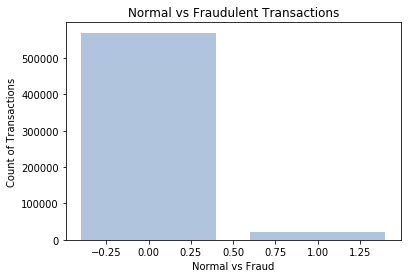

In [11]:
# plot normal vs fraudulent transactions:
plt.bar(df_train.groupby('isFraud')['isFraud'].count().index,
         df_train.groupby('isFraud')['isFraud'].count(), color='lightsteelblue')
plt.ylabel('Count of Transactions')
plt.xlabel('Normal vs Fraud')
plt.title('Normal vs Fraudulent Transactions')

### Transaction Time Delta
TransactionDT is "timedelta from a given reference datetime (not an actual timestamp)." 

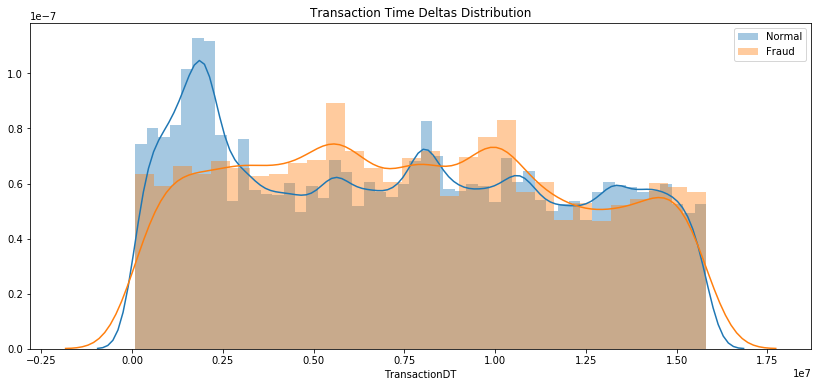

In [12]:
# plot distribution: 
plt.figure(figsize = (14,6))

sns.distplot(df_train.loc[df_train['isFraud'] == 0]['TransactionDT'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['TransactionDT'],kde=True)
plt.title('Transaction Time Deltas Distribution')
plt.legend(['Normal','Fraud'])
plt.show()

In [13]:
# test whether group differences are significant:
ttest_ind(df_train[df_train.isFraud == 0][['TransactionDT']],
          df_train[df_train.isFraud == 1][['TransactionDT']])

Ttest_indResult(statistic=array([-10.07009977]), pvalue=array([7.52352445e-24]))

There is a difference in time deltas between normal and fraudulent transactions. T-test confirms it is statistically significant.

### Transaction Amount
Transaction amount is "transaction payment amount in USD." 

The distribution plot shows outliers, which are two transactions for \\$31937.391 not labeled as fraud. I'll limit the value of outliers and use Tukey's method to confirm there are no other outliers.

Average transaction labeled as fraud is higher than average normal transaction (\\$149.2 vs \\$134.5). T-test confirms that the difference is statistically significant. 

Text(0.5, 1.0, 'Average Transactions Labeled as Normal vs Fraud')

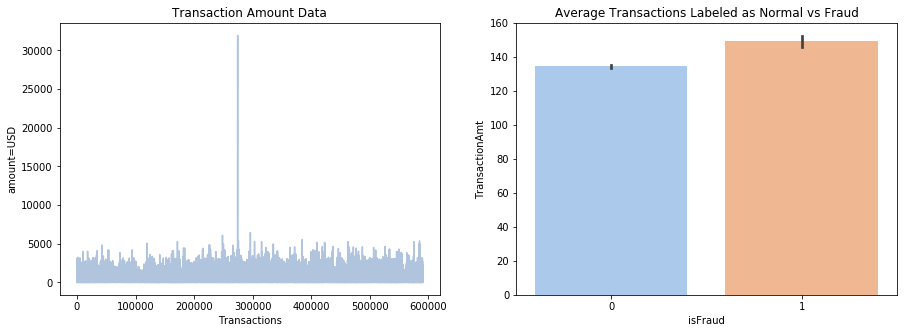

In [14]:
plt.figure(figsize=(15,5))

# plot transaction amount data:
plt.subplot(1,2,1)
plt.plot(df_train['TransactionAmt'], color='lightsteelblue')
plt.title('Transaction Amount Data')
plt.ylabel('amount=USD')
plt.xlabel('Transactions')

# plot normal vs. fraudulent transactions:
plt.subplot(1,2,2)
sns.barplot(df_train['isFraud'], df_train['TransactionAmt'],palette='pastel')
plt.title('Average Transactions Labeled as Normal vs Fraud')

In [15]:
# get mean transaction amount for normal and fraudulent transactions:
df_train[['TransactionAmt','isFraud']].groupby('isFraud').mean()

,TransactionAmt
isFraud,
0,134.511665
1,149.244779


In [16]:
# test whether group differences are significant:
ttest_ind(df_train[df_train.isFraud == 0][['TransactionAmt']],
          df_train[df_train.isFraud == 1][['TransactionAmt']])

Ttest_indResult(statistic=array([-8.6994436]), pvalue=array([3.34346246e-18]))

In [17]:
# review transactions over $7,500:
df_train.loc[df_train['TransactionAmt'] > 7500]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,missing,missing,missing,missing,missing,missing,missing,missing,missing


The score threshold is: 1.0
Number of outliers is: 91539
The score threshold is: 1.5
Number of outliers is: 66482
The score threshold is: 2.0
Number of outliers is: 55384
The score threshold is: 2.5
Number of outliers is: 45084
The score threshold is: 3.0
Number of outliers is: 36422
The score threshold is: 3.5
Number of outliers is: 32455
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


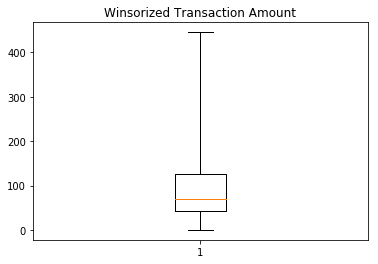

In [18]:
# limit the value of outliers:
df_train['TransactionAmt'] = winsorize(df_train['TransactionAmt'], (0, 0.05))

# plot to review if there are outliers:
plt.boxplot(df_train['TransactionAmt'], whis=10)
plt.title('Winsorized Transaction Amount')

# use Tukey's method to confirm there are no outliers:
q75, q25 = np.percentile(df_train['TransactionAmt'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print('The score threshold is: {}'.format(threshold))
    print('Number of outliers is: {}'.format(
        len((np.where((df_train['TransactionAmt'] > max_val) 
                      | (df_train['TransactionAmt'] < min_val))[0]))
    ))

### Product Code
ProductCD is "product code, the product for each transaction." There are five categories. The meaning of each category is not provided, but there are differences among categories for fraudulent and normal transactions.

ProductCD      C      H      R      S       W
isFraud                                      
0          60511  31450  36273  10942  430701
1           8008   1574   1426    686    8969


Text(0.5, 1.0, 'Normal vs Fraud per Product Code')

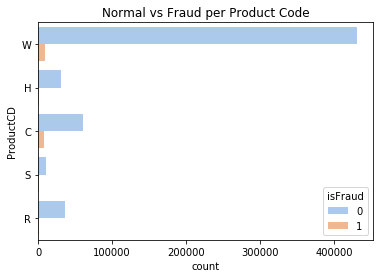

In [19]:
# review number of normal vs fraudulent transaction based on product code: 
count_table = pd.crosstab(df_train['isFraud'], df_train['ProductCD'])
print(count_table)

# plot counts:
sns.countplot(y=df_train['ProductCD'], hue=df_train['isFraud'], palette='pastel')
plt.title('Normal vs Fraud per Product Code')

In [20]:
# test if the differences are statistically significant:
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2656302.643817523, pvalue=0.0)


## Payment Card Information

Variables card1 through card6 are "payment card information, such as card type, card category, issue bank, country, etc." It is stated in data description that these are categorical variables, so I'll impute missing values using most frequent values in each variable. 

In [21]:
# review missing values:
for i in df_train.columns:
    if i.startswith('card'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

card1
0.0
card2
1.5126833068039423
card3
0.26501168422122123
card4
0.0
card5
0.7212043214684865
card6
0.0


In [22]:
# impute data using mode():
for i in df_train.columns:
    if i.startswith('card'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

There is not much insight into what each variable means, but I'll plot the distribution of each to have a quick look at differences in distribution.

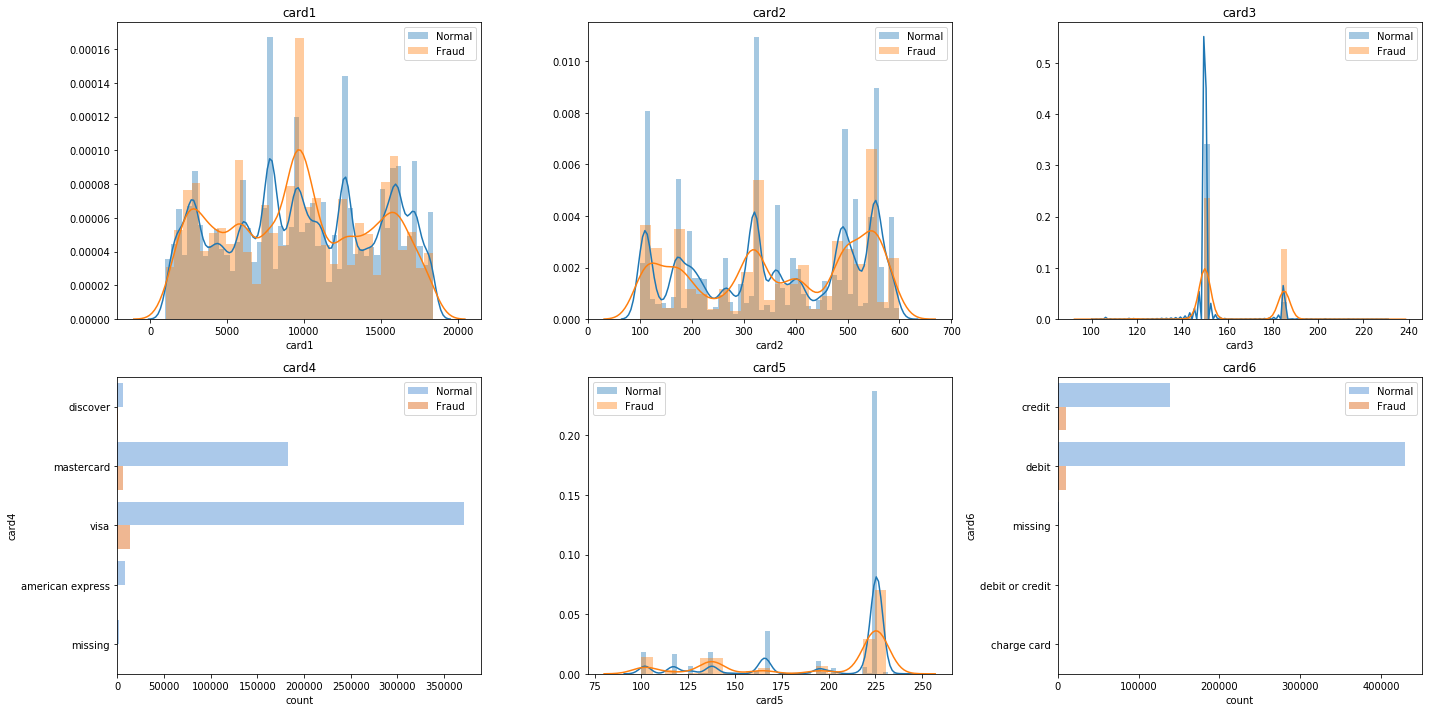

In [23]:
# plot the variables:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card1'])
plt.legend(['Normal','Fraud'])
plt.title('card1')

plt.subplot(2,3,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card2'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card2'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card2')

plt.subplot(2,3,3)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card3'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card3'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card3')

plt.subplot(2,3,4)
sns.countplot(y=df_train['card4'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card4')

plt.subplot(2,3,5)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card5'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card5'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card5')

plt.subplot(2,3,6)
sns.countplot(y=df_train['card6'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card6')
plt.tight_layout()

## Address

Address variables have about 11% of missing data that I'll impute using mode. Data description states that these are also categorical variables, and there is not much insight into what the numbers mean.

In [24]:
# review missing values:
for i in df_train.columns:
    if i.startswith('addr'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

addr1
11.12642666034477
addr2
11.12642666034477


In [25]:
# impute data by mode given that these are categorical variables:
for i in df_train.columns:
    if i.startswith('addr'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

Text(0.5, 1.0, 'addr2')

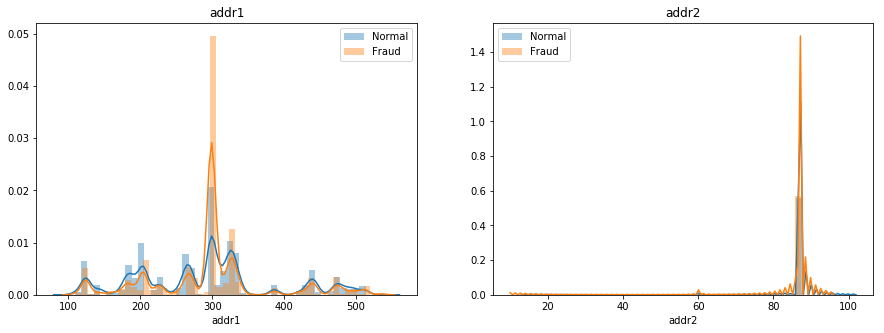

In [26]:
# plot variables distribution: 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr1'])
plt.title('addr1')
plt.legend(['Normal','Fraud'])

plt.subplot(1,2,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr2'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr2'])
plt.legend(['Normal','Fraud'])
plt.title('addr2')

In [27]:
# t-test for addr1 and addr2:
df_train[['addr1','isFraud']].groupby('isFraud').mean()
print('addr1:', ttest_ind(df_train[df_train.isFraud == 0][['addr1']],
          df_train[df_train.isFraud == 1][['addr1']]))

df_train[['addr2','isFraud']].groupby('isFraud').mean()
print('addr2:', ttest_ind(df_train[df_train.isFraud == 0][['addr2']],
          df_train[df_train.isFraud == 1][['addr2']]))

addr1: Ttest_indResult(statistic=array([-6.73792543]), pvalue=array([1.60810346e-11]))
addr2: Ttest_indResult(statistic=array([15.53468183]), pvalue=array([2.07157492e-54]))


T-tests confirm that the differences are statistically significant.

## Distance
dist1 is a  continuous variable with almost 60% of missing values. It has a lot of unique values, so I'll keep the variable and impute missing data using mean.

In [28]:
# review dist variables:
for i in df_train.columns:
    if i.startswith('dist'):
        #print(i)
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column dist1 are: [  19.   nan  287. ... 4851. 2042. 4728.]


In [29]:
# get percentage of missing values:
df_train['dist1'].isnull().sum()*100/df_train['dist1'].isnull().count()

59.6523520845328

In [30]:
#impute missing values:
df_train['dist1'].fillna(df_train['dist1'].mean(), inplace=True)

# t-test:
df_train[['dist1','isFraud']].groupby('isFraud').mean()
ttest_ind(df_train[df_train.isFraud == 0][['dist1']],
          df_train[df_train.isFraud == 1][['dist1']])

Ttest_indResult(statistic=array([-7.99592431]), pvalue=array([1.28835029e-15]))

Text(0.5, 1.0, 'Distance')

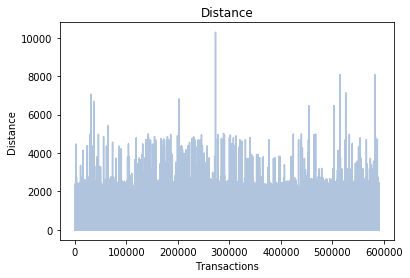

In [31]:
#plot the distribution of the variable:
plt.plot(df_train['dist1'], color='lightsteelblue')
plt.xlabel('Transactions')
plt.ylabel('Distance')
plt.title('Distance')

### Email domains

P_emaildomain is "purchaser email domain." This variable has many categories with uncommon email domains. I'll engineer a new feature with top email domains and everything else in "other" category.

['missing' 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com'
 'anonymous.com' 'hotmail.com' 'verizon.net' 'aol.com' 'me.com'
 'comcast.net' 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com'
 'prodigy.net.mx' 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail'
 'live.com' 'att.net' 'juno.com' 'ymail.com' 'sbcglobal.net'
 'bellsouth.net' 'msn.com' 'q.com' 'yahoo.com.mx' 'centurylink.net'
 'servicios-ta.com' 'earthlink.net' 'hotmail.es' 'cfl.rr.com'
 'roadrunner.com' 'netzero.net' 'gmx.de' 'suddenlink.net'
 'frontiernet.net' 'windstream.net' 'frontier.com' 'outlook.es' 'mac.com'
 'netzero.com' 'aim.com' 'web.de' 'twc.com' 'cableone.net' 'yahoo.fr'
 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net' 'live.fr' 'yahoo.co.uk'
 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk' 'protonmail.com' 'yahoo.co.jp']


Text(0.5, 1.0, 'Purchaser Email Domains')

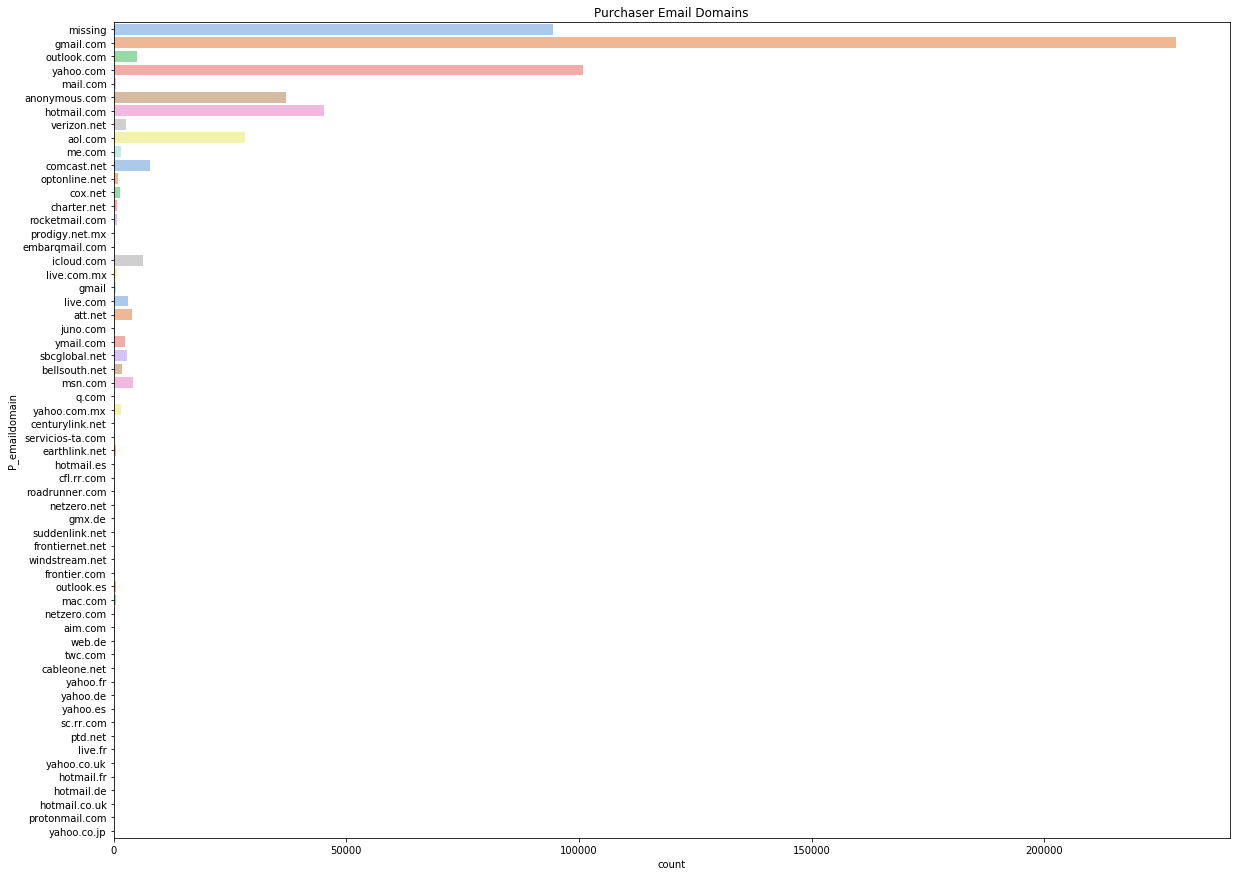

In [32]:
# review unique values:
print(df_train['P_emaildomain'].unique())

# plot the counts of values:
plt.figure(figsize=(20,15))
sns.countplot(y=df_train['P_emaildomain'], palette='pastel')
plt.title('Purchaser Email Domains')

Power_divergenceResult(statistic=array([229066.4913534 ,  15408.58563616]), pvalue=array([0., 0.]))


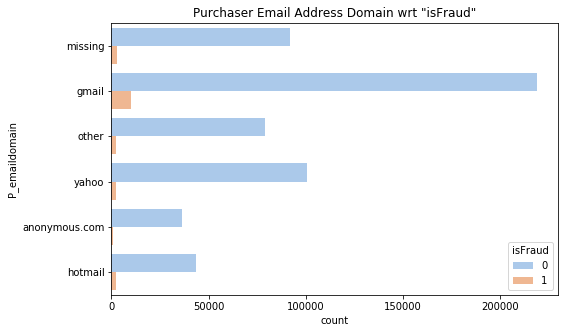

In [33]:
# engineer new feature:
# de-dupe values such as gmail.com and gmail:
df_train['P_emaildomain']= df_train['P_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# create "other category":
df_train.loc[~df_train.P_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'P_emaildomain'] = 'other'

# plot the new variable:
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['P_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Purchaser Email Address Domain wrt "isFraud"')

# test group differences:
count_table = pd.crosstab(df_train['P_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

**R_emaildomain** is "recipient email domain." It has similar unique values and about 75% of missing values. 

Power_divergenceResult(statistic=array([1546743.66430124,   20541.76261917]), pvalue=array([0., 0.]))


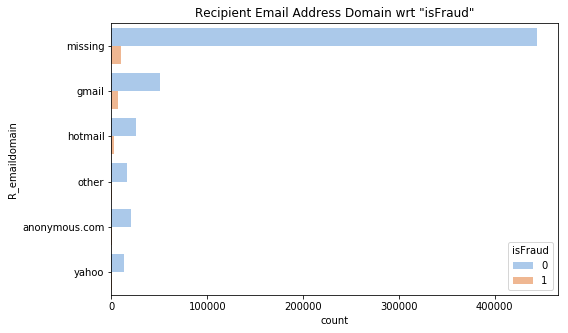

In [34]:
# engineer new feature:
# de-dupe values such as gmail.com and gmail:
df_train['R_emaildomain']= df_train['R_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# create "other category":
df_train.loc[~df_train.R_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'R_emaildomain'] = 'other'

# plot the new variable:
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['R_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Recipient Email Address Domain wrt "isFraud"')

# test group differences:
count_table = pd.crosstab(df_train['R_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

## "Vesta engineered features"
Cxxx, Dxxx, Mxxx and Vxxx are Vesta-engineered features. Given that the actual meaning is masked, it's unclear how to further engineer these features. I'll impute missing values and reduce dimensionality of some of these features.

### C1-C14
"counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked."

In [35]:
# review missing and unique values:
for i in df_train.columns:
    if re.findall(r'^C\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
# #         print('Unique values in column {} are: {}'
# #           .format(i, df_train[i].unique()))

C1
0.0
C2
0.0
C3
0.0
C4
0.0
C5
0.0
C6
0.0
C7
0.0
C8
0.0
C9
0.0
C10
0.0
C11
0.0
C12
0.0
C13
0.0
C14
0.0


Text(0.5, 1.0, 'Correlation of C Features')

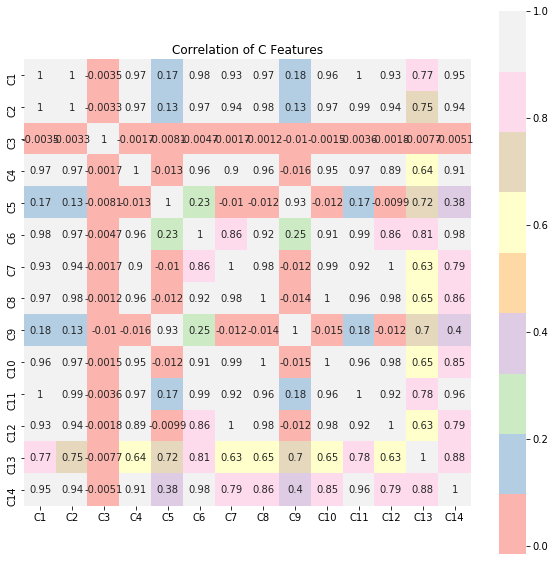

In [36]:
# review correlation: 
plt.figure(figsize=(10,10))

c_check_corr = df_train.filter(regex=('^C\d')).corr()
sns.heatmap(c_check_corr, annot=True, square=True, cmap='Pastel1')
plt.title('Correlation of C Features')

C1-C14 are continuous variables, there are no missing values. Many of these are correlated, which may affect feature importance in tree models.

### D1-D15

"timedelta, such as days between previous transaction, etc."

In [37]:
# review missing values:
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

D1
0.21488806854743117
D2
47.54919226470688
D3
44.514850814508755
D4
28.604666915026925
D5
52.46740271615809
D10
12.873302401192129
D11
47.29349409015477
D15
15.090087038981272


In [38]:
# impute missing values by mean:
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        df_train[i].fillna(df_train[i].mean(), inplace=True)

Text(0.5, 1.0, 'Correlation of D Features')

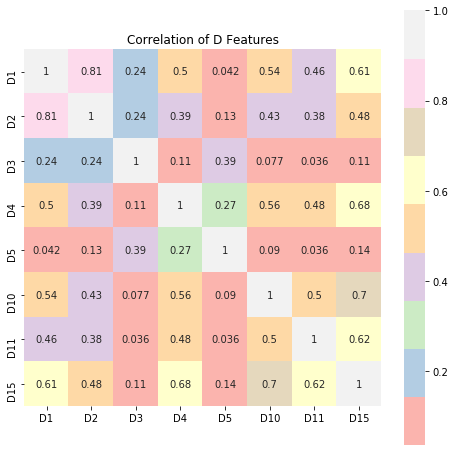

In [39]:
# review correlation: 
d_df = df_train.filter(regex=('^D\d'))

plt.figure(figsize=(8,8))
D_check_corr = d_df.corr()
sns.heatmap(D_check_corr, annot=True, square=True,cmap='Pastel1')
plt.title('Correlation of D Features')

### M1-M9
"match, such as names on card and address, etc." I imputed missing values, but originally some of these variables had almost 50% of missing values.

In [40]:
# review the variables:
for i in df_train.columns:
    if re.findall(r'^M\d', i):
       # print(i)        
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column M1 are: ['T' 'missing' 'F']
Unique values in column M2 are: ['T' 'missing' 'F']
Unique values in column M3 are: ['T' 'missing' 'F']
Unique values in column M4 are: ['M2' 'M0' 'missing' 'M1']
Unique values in column M5 are: ['F' 'T' 'missing']
Unique values in column M6 are: ['T' 'F' 'missing']
Unique values in column M7 are: ['missing' 'F' 'T']
Unique values in column M8 are: ['missing' 'F' 'T']
Unique values in column M9 are: ['missing' 'F' 'T']


### Vxxx

"Vesta engineered rich features, including ranking, counting, and other entity relations." 

I am working with 292 engineered features with no insight into what these variables are. I'll perform principal component analysis (PCA) to reduce dimensionality with understanding that this may influence the behavior of the models.

In [41]:
# review V features
v_df = df_train.filter(regex=('^V\d'))
print(v_df.shape)

# fill missing values with mean:
for i in v_df.columns:
    v_df[i].fillna(v_df[i].mean(),inplace=True)

(590540, 292)


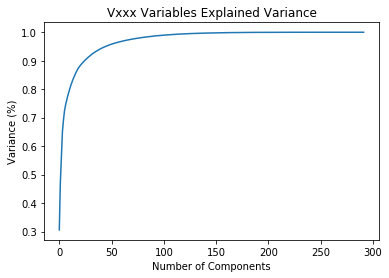

In [42]:
# standardize data:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(v_df)
pca = PCA().fit(data_rescaled)

# plot explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Vxxx Variables Explained Variance')
plt.show()

Instead of using 292 variables, I chose to use 25 that explain about 90% of the variance.

In [43]:
# perform PCA, add new features to the data frame:
pca = PCA(n_components=25)
C_pca = pca.fit_transform(data_rescaled)
principalDf = pd.DataFrame(data = C_pca)

df_train = pd.concat([df_train, principalDf], axis = 1)
df_train = df_train.drop(df_train.filter(regex=('^V\d')),axis=1)

In [44]:
del v_df,principalDf

### DeviceType, DeviceInfo and id

Variables in the identity file are "identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners."

Most of these variables have a lot of missing values. I'll impute data using mean.

## Data Review

Machine learning models expect numeric data, so I'll use label-encoding to transform categorical variables into numeric.

In [45]:
# impute remaining missing values, label encode categorical variables:
encode = LabelEncoder()

for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = encode.fit_transform(df_train[i])
    else:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [46]:
# review final data frame:
# # verify there are no mo missing values:
# df_train.isnull().sum()*100/df_train.isnull().count()

# verify there are only numeric variables:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 93 columns):
TransactionID     590540 non-null int64
isFraud           590540 non-null int64
TransactionDT     590540 non-null int64
TransactionAmt    590540 non-null float64
ProductCD         590540 non-null int64
card1             590540 non-null int64
card2             590540 non-null float64
card3             590540 non-null float64
card4             590540 non-null int64
card5             590540 non-null float64
card6             590540 non-null int64
addr1             590540 non-null float64
addr2             590540 non-null float64
dist1             590540 non-null float64
P_emaildomain     590540 non-null int64
R_emaildomain     590540 non-null int64
C1                590540 non-null float64
C2                590540 non-null float64
C3                590540 non-null float64
C4                590540 non-null float64
C5                590540 non-null float64
C6                590540 

In [47]:
# # export data to a csv file:
# df_train.to_csv('clean_data.csv')

## Model Preparation Summary:

I prepared data for modeling by addressing missing values, limiting outliers, and transforming data into numbers. I also reduced some dimensionality - started with 434 variables and currently have 91 features.


# II. Modeling

I will now use the prepared data to train and pick best model to detect fraud in e-commerce transactions.

In [2]:
# read in data:
df_train = pd.read_csv('clean_data.csv')

In [48]:
# drop TransactionID:
df_train = df_train.drop('TransactionID', axis=1)

# review data:
df_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,15,16,17,18,19,20,21,22,23,24
0,0,86400,68.5,4,13926,321.0,150.0,1,142.0,1,...,-0.022766,-0.014421,0.065157,0.111678,0.033404,0.024916,0.037056,0.024209,-0.024650,-0.033633
1,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,...,-0.015563,0.005251,0.010681,0.020556,0.003558,0.009973,0.006000,-0.007777,0.002997,0.001903
2,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,...,-0.001824,-0.001481,-0.011713,0.003095,0.010953,0.014113,-0.008047,-0.003863,-0.006165,-0.011861
3,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,...,0.112923,-0.056691,-0.062856,0.018936,-0.015491,0.013526,0.010705,0.025055,-0.002721,0.028698
4,0,86506,50.0,1,4497,514.0,150.0,2,102.0,1,...,-0.010601,-0.003628,0.010865,-0.004523,-0.019682,-0.010760,0.001142,0.017362,-0.012364,0.027193


In [4]:
df_train = df_train.drop('Unnamed: 0', axis=1)

## Class Imbalance

To address class imbalance, I'll use Random Undersampling to randomly select samples from the majority class to even it out with the minority class. I'll also train a model after performing Synthetic Minority Oversampling Technique (SMOTE), where I'll synthetically create samples of the minority class to even it out with the majority class.

### Random Undersampling

In [49]:
# keep original data frame for smote:
df_train_smote = df_train.copy()

In [53]:
# split data into train and test sets:
y_train=df_train['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=42)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

# randomly under sample the majority class:
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 456011, 1: 16421})
Resampled dataset shape Counter({0: 16421, 1: 16421})


## Model Evaluation
For model evaluation, I'll use:

- classification report to review precision, recall and F1 score
- roc_auc_score to review true positive rate and false positive rate
- confusion matrix to review false negatives and false positives


## Logistic Regression
I'll use logistic regression with default parameters as a baseline model (Note: I label-encoded categorical variables, which is ok for tree-based models, but can influence the weight of features for logistic regression).

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84    113866
           1       0.08      0.64      0.15      4242

    accuracy                           0.73    118108
   macro avg       0.53      0.69      0.49    118108
weighted avg       0.95      0.73      0.82    118108

-----------------------------------------------
Confusion Matrix:
[[83653 30213]
 [ 1521  2721]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.2558082433027399
Percent Type II errors: 0.012878043824296406
---------------------------------------------
ROC AUC: 0.7597963711499458


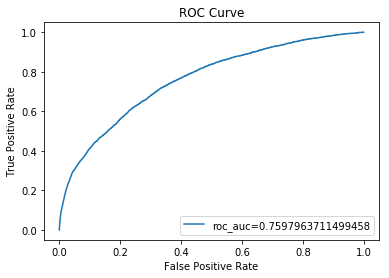

In [54]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, logreg.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Decision Tree

In [55]:
features = df_train.drop('isFraud', axis=1).columns

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113866
           1       0.17      0.45      0.24      4242

    accuracy                           0.90    118108
   macro avg       0.57      0.68      0.60    118108
weighted avg       0.95      0.90      0.92    118108

-----------------------------------------------
Confusion Matrix:
[[104388   9478]
 [  2339   1903]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.0802485860398957
Percent Type II errors: 0.01980390828733024
---------------------------------------------
ROC AUC: 0.7288546560179553


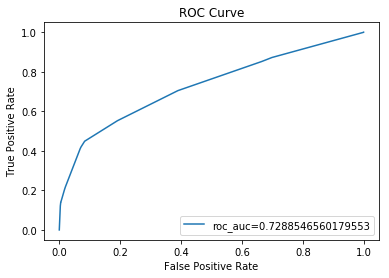

In [56]:
# train decision tree model:
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
dt = dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, dt.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

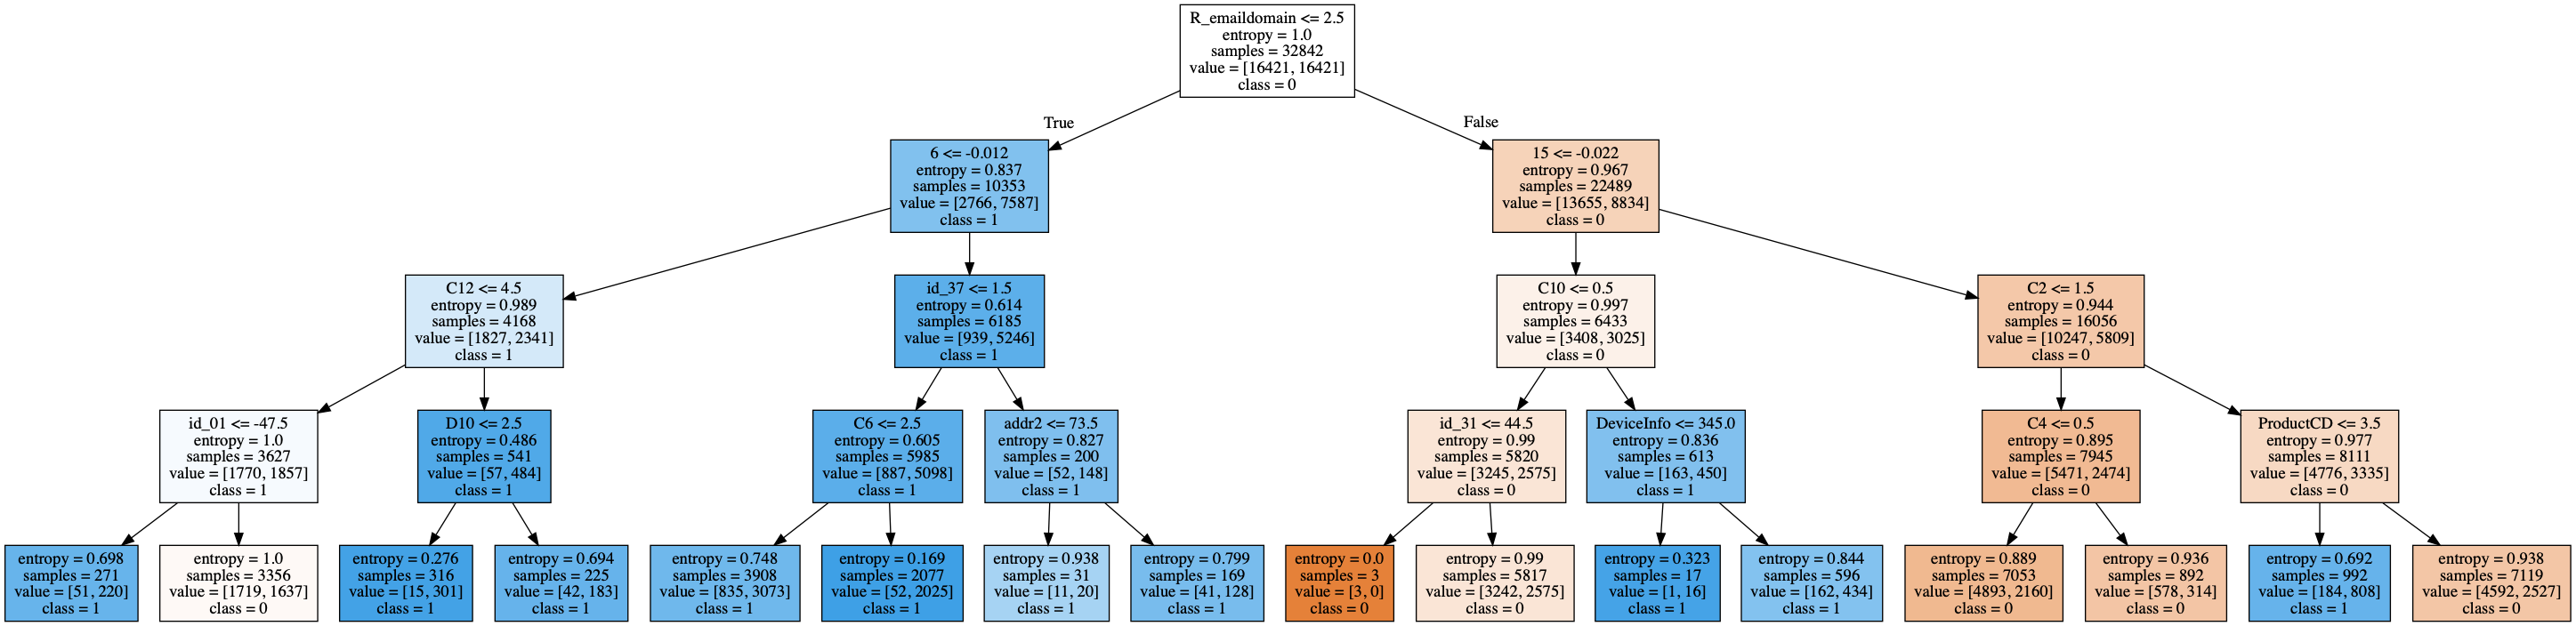

In [57]:
# render the tree:
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=features,
    class_names=['0', '1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113866
           1       0.21      0.84      0.33      4242

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100365  13501]
 [   686   3556]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11431063094794595
Percent Type II errors: 0.0058082433027398656
---------------------------------------------
ROC AUC: 0.9315960896507938


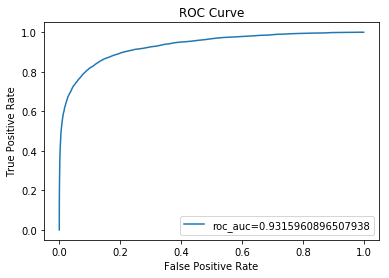

In [58]:
# train the model:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# evaluate the model:
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

I'll use feature importance to review important features.

In [59]:
# review important features:
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                    1 Importance: 0.04
Variable: TransactionDT        Importance: 0.03
Variable: TransactionAmt       Importance: 0.03
Variable: card1                Importance: 0.03
Variable: C13                  Importance: 0.03
Variable: C14                  Importance: 0.03
Variable:                   10 Importance: 0.03
Variable: card2                Importance: 0.02
Variable: addr1                Importance: 0.02
Variable: C1                   Importance: 0.02
Variable: C5                   Importance: 0.02
Variable: D2                   Importance: 0.02
Variable: D3                   Importance: 0.02
Variable:                    3 Importance: 0.02
Variable:                    6 Importance: 0.02
Variable:                    8 Importance: 0.02
Variable:                   16 Importance: 0.02
Variable:                   22 Importance: 0.02
Variable: ProductCD            Importance: 0.01
Variable: card3                Importance: 0.01
Variable: card4                Importanc

Let's retrain the model after dropping unimportant features.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113866
           1       0.21      0.84      0.33      4242

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.96      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100159  13707]
 [   689   3553]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.1160547973041623
Percent Type II errors: 0.005833643783655637
---------------------------------------------
ROC AUC: 0.9307388666229864


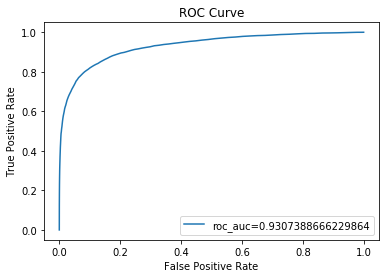

In [60]:
# retrain the model with less features based on feature importance: 
df_train2 = df_train.drop(['addr2','C3', 'M1','M2', 'M3','M7',
                           'M8','M9','id_01','id_05','id_06',
                           'id_11','id_12','id_13','id_15','id_16', 'id_19',
                           'id_28','id_35', 'id_36','id_37','id_38',
                           'DeviceType','DeviceInfo'], axis=1)

# split dataset into train and test sets:
y_train=df_train2['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train2.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=42)
# undersample the majority class:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

# train the model:
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)

# evaluate the model:
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc2.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model did slightly worse than the original model. I'll keep working with the original model.

## Hyperparameters Tuning
I'll tune the hyperparameters of the original random forest model using Grid Search Cross Validation.

In [61]:
# review hyperparameters of the model:
pprint(rfc.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


I'll tune:

- n_estimators -- the number of trees in the forest
- max_features -- the number of features to consider when looking for the best split
- max_depth  -- max number of levels in each decision tree
- criterion -- gini or entropy to measure the quality of a split

In [62]:
# create parameter grid:
param_grid = {
    'max_depth': [None, 80, 100],
    'max_features': ['auto', 2],
    'n_estimators': [100, 300, 1000],
    'criterion':['gini','entropy']
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [61]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 22.1min finished


{'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'auto',
 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113866
           1       0.21      0.84      0.33      4242

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100215  13651]
 [   662   3580]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11558065499373454
Percent Type II errors: 0.005605039455413689
---------------------------------------------
ROC AUC: 0.9327876231483224


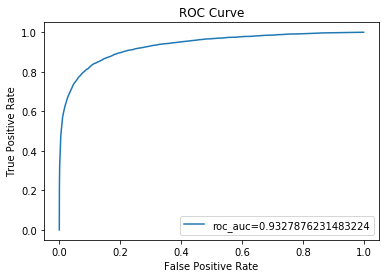

In [63]:
# train random forest with best parameters:
rfc4 = RandomForestClassifier(criterion='gini',
                             max_depth=80,
                             max_features='auto',
                             n_estimators=300)

rfc4.fit(X_train, y_train)
y_pred = rfc4.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc4.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc4.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model with 300 trees did slightly better than the original model with 100 trees.

## Gradient Boosting Classifier

Let's try another ensemble model -- gradient boosting model, which uses boosting instead of bagging when learning from data.

In [64]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=100,
                                          max_depth=2,
                                          loss='deviance')
# train the model:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113866
           1       0.14      0.77      0.24      4242

    accuracy                           0.83    118108
   macro avg       0.57      0.80      0.57    118108
weighted avg       0.96      0.83      0.88    118108

-----------------------------------------------
Confusion Matrix:
[[94362 19504]
 [  988  3254]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.16513699326040573
Percent Type II errors: 0.008365225048260913
---------------------------------------------
ROC AUC: 0.8753137471207895


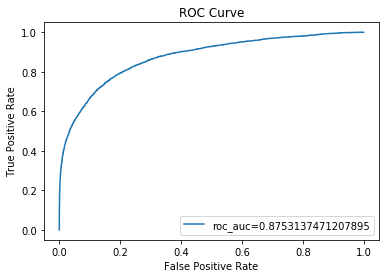

In [65]:
y_pred = gbc.predict(X_test)

# evaluate the model: 
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, gbc.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = gbc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Synthetic Minority Oversampling Technique (SMOTE)
Let's now perform SMOTE on our test data and train a random forest model with 100 trees.

In [66]:
# split and under sample majority in original data:
y_train=df_train_smote['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train_smote.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=42)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

# use SMOTE:
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(ratio='minority',random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 456011, 1: 16421})
Resampled dataset shape Counter({0: 456011, 1: 456011})


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.92      0.55      0.69      4242

    accuracy                           0.98    118108
   macro avg       0.95      0.78      0.84    118108
weighted avg       0.98      0.98      0.98    118108

-----------------------------------------------
Confusion Matrix:
[[113655    211]
 [  1898   2344]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.0017865004910759643
Percent Type II errors: 0.016070037592711757
---------------------------------------------
ROC AUC: 0.9334957621551616


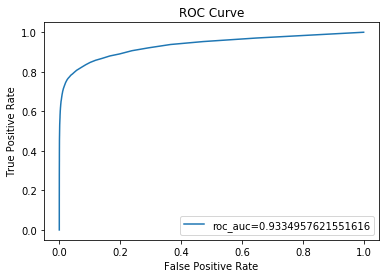

In [67]:
rfcs = RandomForestClassifier(n_estimators=100)
rfcs.fit(X_train, y_train)
y_pred = rfcs.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfcs.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfcs.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
# review hyperparameters of the model:
pprint(rfcs.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [69]:
# create parameter grid:
param_grid = {
    'max_depth': [None, 80, 100],
    'max_features': ['auto', 2],
    'n_estimators': [100, 300, 1000],
    'criterion':['gini','entropy']
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfcs, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(Note: not enough memory on my computer to perform grid search validation on this data.)

## Summary

Below is the summary of performance:

    Model	             AUC	     Precision	 Recall    
    Logistic Regression   0.7597	  0.08	    0.64
    Decision Tree	     0.7288	  0.17	    0.45
    Gradient Boosting	 0.8753	  0.14	    0.77
    Random Forest(300)	0.9327	  0.21	    0.84
    Random Forest(SMOTE)  0.9334	  0.92	    0.55

Random Forest (SMOTE) Classifier scored highest in ROC AUC.

When the cost of false negatives is high, Random Forest (300) is the best model (Recall=0.84). When the cost of false positives is high, Random Forest (SMOTE) is the best model (Precision=0.92)